<a href="https://colab.research.google.com/github/Sarthak-Chauhan-Git/Drug-induced-cardiotoxicity-classification-model/blob/main/Cardiotoxicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DRUG INDUCED CARDIOTOXICITY CLASSIFICATION MODEL**

##Importing necessary libraries

In [ ]:
import sys
import os
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import MolToSmiles
from rdkit.Chem import Draw
print("RDKit pip installation command executed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 37.9 MB/s eta 0:00:00
RDKit pip installation command executed.


In [ ]:
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, MaxPooling1D,
    LSTM, GlobalMaxPooling1D, GlobalAveragePooling2D,
    Concatenate, Dense, Dropout, Reshape,
    MultiHeadAttention, LayerNormalization, Add,
    Flatten
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from google.colab import drive

print("Necessary libraries imported.")

Necessary libraries imported.


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##Dataset

In [ ]:
from google.colab import drive
# If this fails with 'credential propagation' error, check browser cookies or use the 'Mount Drive' button in the file explorer.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ARTIFACTS_DIR = Path("/content/drive/MyDrive/Research paper/Cardiotoxicity/artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# Common path if the file is in the root of your Google Drive
DRIVE_ROOT = Path("/content/drive/MyDrive/Research paper/Cardiotoxicity")

# Pipeline 1 training dataset
p1_train_path = DRIVE_ROOT / "Features of train data(pipeline 1)" / "cardiotrainall_merged.csv"
df_p1_train = pd.read_csv(p1_train_path, low_memory=False)

# Pipeline 1 test datasets
p1_test_neg_path = DRIVE_ROOT / "Features of test data(pipeline 1)" / "cardiotestnegall_merged.csv"
p1_test_new_path = DRIVE_ROOT / "Features of test data(pipeline 1)" / "cardiotestnewall_merged.csv"
p1_test_pos_path = DRIVE_ROOT / "Features of test data(pipeline 1)" / "cardiotestposall_merged.csv"
df_p1_test_neg = pd.read_csv(p1_test_neg_path, low_memory=False)
df_p1_test_new = pd.read_csv(p1_test_new_path, low_memory=False)
df_p1_test_pos = pd.read_csv(p1_test_pos_path, low_memory=False)

# Pipeline 2 and 3 training dataset
labeled_train_path = DRIVE_ROOT / "labeled train data" / "train_validation_cardio_tox_data.csv"
df_labeled_train = pd.read_csv(labeled_train_path, low_memory=False)

# Pipeline 2 and 3 test dataset
labeled_test_neg_path = DRIVE_ROOT / "labeled test data" / "external_test_set_neg.csv"
labeled_test_new_path = DRIVE_ROOT / "labeled test data" / "external_test_set_new.csv"
labeled_test_pos_path = DRIVE_ROOT / "labeled test data" / "external_test_set_pos.csv"
df_labeled_test_neg = pd.read_csv(labeled_test_neg_path, low_memory=False)
df_labeled_test_new = pd.read_csv(labeled_test_new_path, low_memory=False)
df_labeled_test_pos = pd.read_csv(labeled_test_pos_path, low_memory=False)

# Check all datasets
datasets = {
    "P1 Train": df_p1_train,
    "P1 Test NEG": df_p1_test_neg,
    "P1 Test NEW": df_p1_test_new,
    "P1 Test POS": df_p1_test_pos,
    "Labeled Train": df_labeled_train,
    "Labeled Test NEG": df_labeled_test_neg,
    "Labeled Test NEW": df_labeled_test_new,
    "Labeled Test POS": df_labeled_test_pos,
}

for name, df in datasets.items():
    print(f"{name}: {df.shape}")

required_files = [
    p1_train_path, p1_test_neg_path, p1_test_new_path, p1_test_pos_path,
    labeled_train_path, labeled_test_neg_path, labeled_test_new_path, labeled_test_pos_path
]

for file_path in required_files:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Required file not found: {file_path}")

P1 Train: (12620, 2661)
P1 Test NEG: (41, 2661)
P1 Test NEW: (740, 2661)
P1 Test POS: (44, 2661)
Labeled Train: (12620, 997)
Labeled Test NEG: (41, 2)
Labeled Test NEW: (740, 2)
Labeled Test POS: (44, 2)


## Graphs function

In [ ]:
def plot_training_curves(history, title_prefix):
    """
    Plots loss and accuracy curves from a Keras History object
    """
    # ----- LOSS -----
    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----- ACCURACY -----
    plt.figure()
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_training_curves_auc(history, title_prefix):
    # ----- LOSS -----
    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----- AUC -----
    plt.figure()
    plt.plot(history.history["auc"], label="Train AUC")
    plt.plot(history.history["val_auc"], label="Val AUC")
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.title(f"{title_prefix} - AUC")
    plt.legend()
    plt.grid(True)
    plt.show()

## PIPELINE 1 TRAINING

In [ ]:
df_labels = df_labeled_train[["smiles", "ACTIVITY"]]
df_p1_train = df_p1_train.merge(
    df_labels,
    on="smiles",
    how="inner"
)
df_p1_train.head()

,smiles,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,ACTIVITY
0,Fc1ccc(-n2cc(NCCN3CCCCC3)nn2)cc1F,17.108462,13.312773,0,1,28.921462442128103,2.373945611498825,4.682480546261369,28.921462442128103,1.314611929187641,...,0,0,0,0,0,0,0,0,0,1
1,COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...,26.886637,19.283801,0,1,45.24146180150045,2.4969313129533863,4.859531950325856,45.24146180150045,1.3306312294558955,...,0,0,0,0,0,0,0,0,0,0
2,CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...,28.187229,20.640811,0,1,44.53100555459368,2.503887481571362,4.90882548276605,44.53100555459368,1.2369723765164913,...,0,0,0,0,0,0,0,0,0,0
3,N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...,27.105416,18.346730,0,2,44.82814943738795,2.437731702917685,4.8754634058353705,44.82814943738795,1.3184749834525868,...,0,0,0,0,0,0,0,0,0,0
4,O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...,25.880229,18.463716,0,0,42.55694816230451,2.4468444155990423,4.8936888311980855,42.55694816230451,1.2896044897668033,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
drop_cols = ["smiles", "ACTIVITY"]

X1_train = df_p1_train.drop(columns=drop_cols, errors="ignore")
y_train  = df_p1_train["ACTIVITY"]
print("X shape:", X1_train.shape)
print("y shape:", y_train.shape)

X shape: (12620, 2660)
y shape: (12620,)


In [ ]:
# X1_train is still a DataFrame at this point
X1_train = X1_train.apply(
    lambda col: pd.to_numeric(col, errors="coerce")
)

all_nan_cols = X1_train.columns[X1_train.isna().all()].tolist()
print(f"All-NaN columns: {len(all_nan_cols)}")
X1_train = X1_train.drop(columns=all_nan_cols)
remaining_cols = X1_train.columns.tolist()
print(f"Remaining columns: {len(remaining_cols)}")
joblib.dump(remaining_cols, ARTIFACTS_DIR / "p1_remaining_cols.pkl")

imputer = SimpleImputer(strategy="median")
X1_train = imputer.fit_transform(X1_train)

scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)

vt = VarianceThreshold(threshold=1e-5)
X1_train = vt.fit_transform(X1_train)

All-NaN columns: 88
Remaining columns: 2572


In [ ]:
joblib.dump(all_nan_cols, ARTIFACTS_DIR / "p1_all_nan_cols.pkl")
joblib.dump(imputer, ARTIFACTS_DIR / "p1_imputer.pkl")
joblib.dump(scaler, ARTIFACTS_DIR / "p1_scaler.pkl")
joblib.dump(vt, ARTIFACTS_DIR / "p1_variance_filter.pkl")

['/content/drive/MyDrive/Research paper/Cardiotoxicity/artifacts/p1_variance_filter.pkl']

In [ ]:
descriptor_input = Input(shape=(X1_train.shape[1],))

x = Dense(512, activation="relu")(descriptor_input)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)

descriptor_output = Dense(1, activation="sigmoid")(x)

descriptor_model = Model(descriptor_input, descriptor_output)

descriptor_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        ARTIFACTS_DIR / "pipeline1_descriptor_best.keras",
        monitor="val_auc",
        mode="max",
        save_best_only=True
    )
]

history_p1 = descriptor_model.fit(
    X1_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.15,
    callbacks=callbacks
)

Epoch 1/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6736 - auc: 0.7191 - loss: 0.7690 - val_accuracy: 0.7602 - val_auc: 0.8532 - val_loss: 0.4792
Epoch 2/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7631 - auc: 0.8475 - loss: 0.4888 - val_accuracy: 0.8014 - val_auc: 0.8793 - val_loss: 0.4434
Epoch 3/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7903 - auc: 0.8729 - loss: 0.4484 - val_accuracy: 0.8019 - val_auc: 0.8870 - val_loss: 0.4264
Epoch 4/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8037 - auc: 0.8924 - loss: 0.4125 - val_accuracy: 0.7982 - val_auc: 0.8823 - val_loss: 0.4343
Epoch 5/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8256 - auc: 0.9082 - loss: 0.3840 - val_accuracy: 0.8104 - val_auc: 0.8955 - val_loss: 0.4112
Epoch 6/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8348 - auc: 0.9164 - loss: 0.3682 - val_accuracy: 0.8183 - val_auc: 0.8984 - val_loss: 0.4073
Epoch 7/100
336/336 ━━━━━━━━━━━━

In [ ]:
print(f"\n{'='*60}")
print(f"✓ PIPELINE 1 COMPLETE")
print(f"  Best validation AUC: {max(history_p1.history['val_auc']):.4f}")
print(f"  Final training loss: {history_p1.history['loss'][-1]:.4f}")
print(f"{'='*60}\n")


✓ PIPELINE 1 COMPLETE
  Best validation AUC: 0.9152
  Final training loss: 0.2455



In [ ]:
descriptor_feature_extractor = tf.keras.Model(
    inputs=descriptor_model.input,
    outputs=descriptor_model.layers[-2].output
)

descriptor_feature_extractor.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2196)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,124,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,256,192 (4.79 MB)

 Trainable params: 1,256,192 (4.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
descriptor_feature_extractor.save(
    ARTIFACTS_DIR / "pipeline1_descriptor_feature_extractor.keras"
)

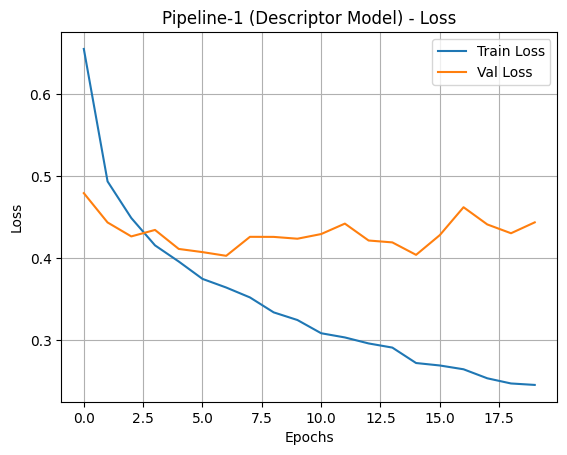

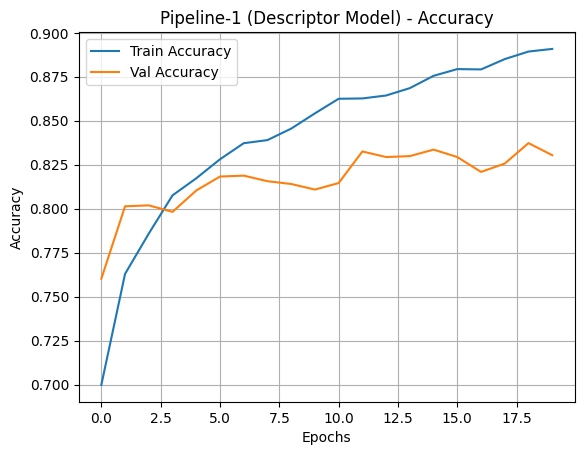

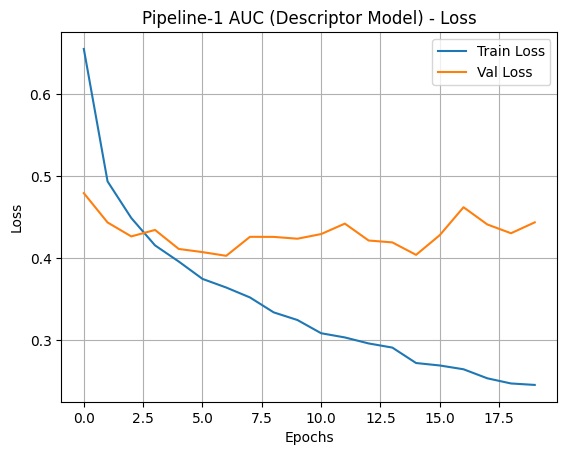

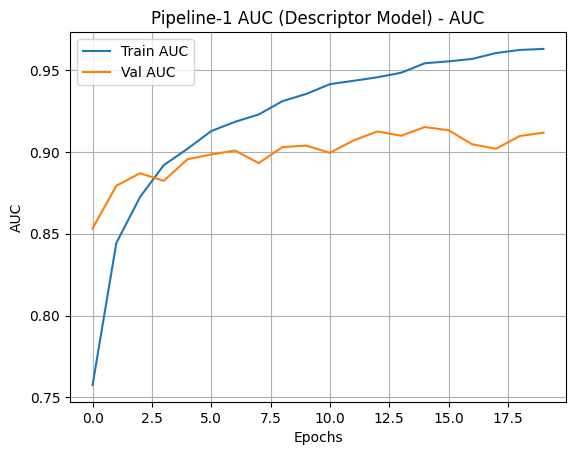

In [ ]:
plot_training_curves(
    history_p1,
    title_prefix="Pipeline-1 (Descriptor Model)"
)
plot_training_curves_auc(
    history_p1,
    title_prefix="Pipeline-1 AUC (Descriptor Model)"
)

## PIPELINE 2 TRAINING


In [ ]:
data = df_labeled_train[["smiles", "ACTIVITY"]].copy()
data.head()

def smiles_to_mol(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None

data["mol"] = data["smiles"].apply(smiles_to_mol)

# Remove invalid SMILES
data = data.dropna(subset=["mol"]).reset_index(drop=True)

print("Valid molecules:", data.shape[0])

Valid molecules: 12620


In [ ]:
data["canon_smiles"] = data["mol"].apply(
    lambda m: MolToSmiles(m, canonical=True)
)

In [ ]:
smiles = data["canon_smiles"].astype(str).values
y = data["ACTIVITY"].values

In [ ]:
MAX_LEN = 120

tokenizer = Tokenizer(
    char_level=True,
    lower=False,
    filters=None
)

tokenizer.fit_on_texts(smiles)

sequences = tokenizer.texts_to_sequences(smiles)
X_smiles = pad_sequences(
    sequences,
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

vocab_size = len(tokenizer.word_index) + 1

print("Vocab size:", vocab_size)
print("Input shape:", X_smiles.shape)

Vocab size: 38
Input shape: (12620, 120)


In [ ]:
joblib.dump(tokenizer, ARTIFACTS_DIR / "pipeline2_smiles_tokenizer.pkl")

['/content/drive/MyDrive/Research paper/Cardiotoxicity/artifacts/pipeline2_smiles_tokenizer.pkl']

In [ ]:
X2_train, X2_val, y2_train, y2_val = train_test_split(
    X_smiles,
    y,
    test_size=0.15,      # validation split
    random_state=42,
    stratify=y
)

In [ ]:
smiles_input = Input(shape=(MAX_LEN,))

# Embedding
x = Embedding(
    input_dim=vocab_size,
    output_dim=128,
    mask_zero=False
)(smiles_input)

# CNN branch
cnn = Conv1D(128, 5, activation="relu")(x)
cnn = MaxPooling1D(2)(cnn)
cnn = GlobalMaxPooling1D()(cnn)

# LSTM branch
lstm = LSTM(
    128,
    return_sequences=True,
    dropout=0.2,
    recurrent_dropout=0.0)(x)
lstm = GlobalMaxPooling1D()(lstm)

# Merge
features = Concatenate()([cnn, lstm])
features = Dense(128, activation="relu")(features)

# Classification head (temporary)
output = Dense(1, activation="sigmoid")(features)

smiles_model = Model(smiles_input, output)

In [ ]:
smiles_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

smiles_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 120, 128)  │      4,864 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 116, 128)  │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 58, 128)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 120, 128)  │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ max_pooling1d[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ lstm[0][0]        │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 251,521 (982.50 KB)

 Trainable params: 251,521 (982.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        ARTIFACTS_DIR / "pipeline2_smiles_best.keras",
        monitor="val_auc",
        mode="max",
        save_best_only=True
    )
]

history_p2 = smiles_model.fit(
    X2_train,
    y2_train,
    validation_data=(X2_val, y2_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.6079 - auc: 0.6542 - loss: 0.6470 - val_accuracy: 0.6598 - val_auc: 0.7952 - val_loss: 0.6030
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7145 - auc: 0.7920 - loss: 0.5509 - val_accuracy: 0.6403 - val_auc: 0.8280 - val_loss: 0.6549
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7553 - auc: 0.8378 - loss: 0.4983 - val_accuracy: 0.7528 - val_auc: 0.8471 - val_loss: 0.4968
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7812 - auc: 0.8650 - loss: 0.4572 - val_accuracy: 0.7464 - val_auc: 0.8584 - val_loss: 0.5021
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7938 - auc: 0.8798 - loss: 0.4343 - val_accuracy: 0.7734 - val_auc: 0.8567 - val_loss: 0.4821
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8007 - auc: 0.8884 - loss: 0.4194 - val_accuracy: 0.7433 - val_auc: 0.8588 - val_loss: 0.5127
Epoch 7/50
336/336 ━━━━━━━━━━━━━━

In [ ]:
print(f"\n{'='*60}")
print(f"✓ PIPELINE 2 COMPLETE")
print(f"  Best validation AUC: {max(history_p2.history['val_auc']):.4f}")
print(f"  Final training loss: {history_p2.history['loss'][-1]:.4f}")
print(f"{'='*60}\n")


✓ PIPELINE 2 COMPLETE
  Best validation AUC: 0.8884
  Final training loss: 0.2040



In [ ]:
smiles_model.save(
    ARTIFACTS_DIR / "pipeline2_smiles_classifier.keras"
)

In [ ]:
smiles_feature_extractor = tf.keras.Model(
    inputs=smiles_model.input,
    outputs=smiles_model.layers[-2].output  # 128-dim embedding
)

smiles_feature_extractor.trainable = False

smiles_feature_extractor.save(
    ARTIFACTS_DIR / "pipeline2_smiles_feature_extractor.keras"
)

In [ ]:
plot_training_curves(
    history_p2,
    title_prefix="Pipeline-2 (SMILES Model)"
)
plot_training_curves_auc(
    history_p2,
    title_prefix="Pipeline-2 AUC (SMILES Model)"
)

## PIPELINE 3 TRAINING

In [ ]:
data_img = df_labeled_train[["smiles", "ACTIVITY"]].copy()

In [ ]:
def smiles_to_mol(smiles):
    try:
        return Chem.MolFromSmiles(smiles)
    except:
        return None

data_img["mol"] = data_img["smiles"].apply(smiles_to_mol)
data_img = data_img.dropna(subset=["mol"]).reset_index(drop=True)
data_img["img_id"] = np.arange(len(data_img))

print("Valid molecules:", len(data_img))

Valid molecules: 12620


In [ ]:
IMG_DIR = "/content/drive/MyDrive/Research paper/Cardiotoxicity/Mol_images_train(Pipeline3)"
os.makedirs(IMG_DIR, exist_ok=True)

In [ ]:
for _, row in data_img.iterrows():
    mol = row["mol"]
    img_id = row["img_id"]

    img = Draw.MolToImage(mol, size=(224, 224))
    img.save(f"{IMG_DIR}/{img_id}.png")

KeyboardInterrupt: 

In [ ]:
y_img = data_img["ACTIVITY"].values

In [ ]:
class ImageSequence(Sequence):
    def __init__(self, indices, labels, img_dir, batch_size=16):
        self.indices = indices
        self.labels = labels
        self.img_dir = img_dir
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, idx):
        batch = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        images, y = [], []
        for i in batch:
            img = load_img(
                f"{self.img_dir}/{i}.png",
                target_size=(224,224)
            )
            img = img_to_array(img)
            img = preprocess_input(img)
            images.append(img)
            y.append(self.labels[i])

        return np.array(images), np.array(y)

In [ ]:
image_input = Input(shape=(224,224,3))

base_cnn = ResNet50(
    weights="imagenet",
    include_top=False,
    input_tensor=image_input
)
base_cnn.trainable = False   # IMPORTANT

x = GlobalAveragePooling2D()(base_cnn.output)
image_features = Dense(128, activation="relu")(x)

# Temporary classification head
output = Dense(1, activation="sigmoid")(image_features)

image_model = Model(image_input, output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
image_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

image_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
img_indices = np.arange(len(data_img))

img_train_idx, img_val_idx = train_test_split(
    img_indices,
    test_size=0.15,
    stratify=y_img,
    random_state=42
)

train_gen = ImageSequence(img_train_idx, y_img, IMG_DIR, batch_size=16)
val_gen   = ImageSequence(img_val_idx, y_img, IMG_DIR, batch_size=16)

callbacks = [
    EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        ARTIFACTS_DIR / "pipeline3_image_best.keras",
        monitor="val_auc",
        mode="max",
        save_best_only=True
    )
]

history_p3 = image_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
132/671 ━━━━━━━━━━━━━━━━━━━━ 26:29 3s/step - accuracy: 0.5230 - auc: 0.5182 - loss: 0.8727

KeyboardInterrupt: 

In [ ]:
print(f"\n{'='*60}")
print(f"✓ PIPELINE 3 COMPLETE")
print(f"  Best validation AUC: {max(history_p3.history['val_auc']):.4f}")
print(f"  Final training loss: {history_p3.history['loss'][-1]:.4f}")
print(f"{'='*60}\n")

In [ ]:
image_model.save(
    ARTIFACTS_DIR / "pipeline3_image_classifier.keras"
)

In [ ]:
image_feature_extractor = tf.keras.Model(
    inputs=image_model.input,
    outputs=image_model.layers[-2].output   # 128-dim embedding
)

image_feature_extractor.trainable = False

image_feature_extractor.save(
    ARTIFACTS_DIR / "pipeline3_image_feature_extractor.keras"
)

In [ ]:
plot_training_curves(
    history_p3,
    title_prefix="Pipeline-3 (Image CNN Model)"
)
plot_training_curves_auc(
    history_p3,
    title_prefix="Pipeline-3 AUC (Image CNN Model)"
)

## FUSION

In [ ]:
def preprocess_p1(df):
    all_nan_cols = joblib.load(ARTIFACTS_DIR / "p1_all_nan_cols.pkl")
    remaining_cols = joblib.load(ARTIFACTS_DIR / "p1_remaining_cols.pkl")
    X = df.drop(columns=["smiles", "ACTIVITY"] + all_nan_cols, errors="ignore")
    X = X.apply(lambda c: pd.to_numeric(c, errors="coerce"))
    for col in remaining_cols:
        if col not in X.columns:
            X[col] = 0
    X = X[remaining_cols]
    X = imputer.transform(X)
    X = scaler.transform(X)
    X = vt.transform(X)
    return X

In [ ]:
def preprocess_p2(df):
    seqs = tokenizer.texts_to_sequences(df["smiles"].astype(str))
    return pad_sequences(seqs, maxlen=MAX_LEN, padding="post")

In [ ]:
def load_images(img_ids, img_dir):
    images = []
    for img_id in img_ids:
        try:
            img = load_img(
                f"{img_dir}/{img_id}.png",
                target_size=(224,224)
            )
            img = img_to_array(img)
            img = preprocess_input(img)
            images.append(img)
        except Exception as e:
            print(f"Warning: Could not load image {img_id}: {e}")
            # Create a black placeholder image
            images.append(np.zeros((224, 224, 3)))

    if len(images) == 0:
        raise ValueError(f"No images could be loaded from {img_dir}")

    return np.array(images)

In [ ]:
df_fusion = (
    df_labeled_train
    .merge(df_p1_train, on=["smiles", "ACTIVITY"], how="inner")
    .merge(data_img[["smiles", "img_id"]], on="smiles", how="inner")
    .reset_index(drop=True)
)

idx_train, idx_val = train_test_split(
    np.arange(len(df_fusion)),
    test_size=0.15,
    stratify=df_fusion["ACTIVITY"],
    random_state=42
)

X1_fusion = preprocess_p1(df_fusion.iloc[idx_train])
X2_fusion = preprocess_p2(df_fusion.iloc[idx_train])
X3_fusion = load_images(
    df_fusion.iloc[idx_train]["img_id"].values,
    IMG_DIR
)
y_fusion = df_fusion.iloc[idx_train]["ACTIVITY"].values

X1_val = preprocess_p1(df_fusion.iloc[idx_val])
X2_val = preprocess_p2(df_fusion.iloc[idx_val])
X3_val = load_images(
    df_fusion.iloc[idx_val]["img_id"].values,
    IMG_DIR
)
y_val = df_fusion.iloc[idx_val]["ACTIVITY"].values

In [ ]:
desc_extractor = load_model(
    ARTIFACTS_DIR / "pipeline1_descriptor_feature_extractor.keras"
)
smiles_extractor = load_model(
    ARTIFACTS_DIR / "pipeline2_smiles_feature_extractor.keras"
)
image_extractor = load_model(
    ARTIFACTS_DIR / "pipeline3_image_feature_extractor.keras"
)

# Freeze everything
desc_extractor.trainable = False
smiles_extractor.trainable = False
image_extractor.trainable = False

In [ ]:
desc_input = Input(shape=(X1_fusion.shape[1],), name="descriptor_input")
smiles_input = Input(shape=(MAX_LEN,), name="smiles_input")
image_input  = Input(shape=(224,224,3), name="image_input")

In [ ]:
Fd = desc_extractor(desc_input)     # (None, 256)
Fs = smiles_extractor(smiles_input) # (None, 128)
Fi = image_extractor(image_input)   # (None, 128)
print(Fd,Fs,Fi)

In [ ]:
Fd = Dense(128, activation="relu")(Fd)  # 256 → 128
Fs = Dense(128, activation="relu")(Fs)
Fi = Dense(128, activation="relu")(Fi)

In [ ]:
Fd = Reshape((1, 128))(Fd)
Fs = Reshape((1, 128))(Fs)
Fi = Reshape((1, 128))(Fi)

modalities = Concatenate(axis=1)([Fd, Fs, Fi])
print(modalities)

In [ ]:
attn_out = MultiHeadAttention(
    num_heads=4,
    key_dim=32
)(modalities, modalities)

# Residual + normalization
attn_out = Add()([modalities, attn_out])
attn_out = LayerNormalization()(attn_out)

In [ ]:
x = Flatten()(attn_out)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

output = Dense(1, activation="sigmoid")(x)

In [ ]:
fusion_model = tf.keras.Model(
    inputs=[desc_input, smiles_input, image_input],
    outputs=output
)

fusion_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

fusion_model.summary()

In [ ]:
callbacks = [
    EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        ARTIFACTS_DIR / "fusion_best.keras",
        monitor="val_auc",
        mode="max",
        save_best_only=True
    )
]

history_fusion = fusion_model.fit(
    [X1_fusion, X2_fusion, X3_fusion],
    y_fusion,
    validation_data=([X1_val, X2_val, X3_val], y_val),
    epochs=50,
    batch_size=16,
    callbacks=callbacks
)

In [ ]:
print(f"\n{'='*60}")
print(f"✓ FUSION MODEL COMPLETE")
print(f"  Best validation AUC: {max(history_fusion.history['val_auc']):.4f}")
print(f"  Final training loss: {history_fusion.history['loss'][-1]:.4f}")
print(f"{'='*60}\n")

In [ ]:
fusion_model.save(
    ARTIFACTS_DIR / "final_multimodal_fusion_model.keras"
)

In [ ]:
plot_training_curves(
    history_fusion,
    title_prefix="Fusion Model (Descriptors + SMILES + Images)"
)
plot_training_curves_auc(
    history_fusion,
    title_prefix="Fusion Model AUC (Descriptors + SMILES + Images)"
)

## TESTING

In [ ]:
# pipeline 3 test image
def generate_images(df, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    success_count = 0
    fail_count = 0
    for idx, row in df.iterrows():
        try:
            mol = Chem.MolFromSmiles(row["smiles"])
            if mol:
                img = Draw.MolToImage(mol, size=(224,224))
                img.save(f"{out_dir}/{row['img_id']}.png")
                success_count += 1
            else:
                print(f"Warning: Could not create molecule from SMILES at index {idx}")
                fail_count += 1
        except Exception as e:
            print(f"Error generating image for index {idx}: {e}")
            fail_count += 1

    print(f"Image generation complete: {success_count} successful, {fail_count} failed")
    return success_count

IMG_NEG_DIR = "/content/drive/MyDrive/Research paper/Cardiotoxicity/Mol_images_test_NEG"
IMG_NEW_DIR = "/content/drive/MyDrive/Research paper/Cardiotoxicity/Mol_images_test_NEW"
IMG_POS_DIR = "/content/drive/MyDrive/Research paper/Cardiotoxicity/Mol_images_test_POS"

# add img_id to test sets ONCE
for df in [df_labeled_test_neg, df_labeled_test_new, df_labeled_test_pos]:
    df["img_id"] = np.arange(len(df))

generate_images(df_labeled_test_neg, IMG_NEG_DIR)
generate_images(df_labeled_test_new, IMG_NEW_DIR)
generate_images(df_labeled_test_pos, IMG_POS_DIR)

In [ ]:
df_p1_test_neg = df_p1_test_neg.merge(
    df_labeled_test_neg[["smiles", "ACTIVITY"]],
    on="smiles",
    how="inner"
)
df_p1_test_new = df_p1_test_new.merge(
    df_labeled_test_new[["smiles", "ACTIVITY"]],
    on="smiles",
    how="inner"
)
df_p1_test_pos = df_p1_test_pos.merge(
    df_labeled_test_pos[["smiles", "ACTIVITY"]],
    on="smiles",
    how="inner"
)

In [ ]:
fusion_model = load_model(
    ARTIFACTS_DIR / "final_multimodal_fusion_model.keras"
)

# Pipeline-1 preprocessors
imputer = joblib.load(ARTIFACTS_DIR / "p1_imputer.pkl")
scaler  = joblib.load(ARTIFACTS_DIR / "p1_scaler.pkl")

# Pipeline-2 tokenizer
tokenizer = joblib.load(
    ARTIFACTS_DIR / "pipeline2_smiles_tokenizer.pkl"
)

In [ ]:
# load vt
vt = joblib.load(ARTIFACTS_DIR / "p1_variance_filter.pkl")

In [ ]:
def evaluate_test_set(df_test, img_dir):
    X1 = preprocess_p1(df_test)
    X2 = preprocess_p2(df_test)
    X3 = load_images(df_test["img_id"].values, img_dir)

    y = df_test["ACTIVITY"].values

    y_prob = fusion_model.predict([X1, X2, X3]).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    return y, y_pred, y_prob

In [ ]:
results = {}

for name, df_test, img_dir in [
    ("NEG", df_labeled_test_neg, IMG_NEG_DIR),
    ("NEW", df_labeled_test_new, IMG_NEW_DIR),
    ("POS", df_labeled_test_pos, IMG_POS_DIR),
]:
    y_true, y_pred, y_prob = evaluate_test_set(df_test, img_dir)
    results[name] = (y_true, y_pred, y_prob)

## RESULTS

Whole model

In [ ]:
def compute_metrics(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_prob),
        "F1": f1_score(y_true, y_pred)
    }

In [ ]:
fusion_results = []

for name, (y_true, y_pred, y_prob) in results.items():
    metrics = compute_metrics(y_true, y_pred, y_prob)
    metrics["Test Set"] = name
    fusion_results.append(metrics)

fusion_df = pd.DataFrame(fusion_results)
fusion_df

Pipeline 1

In [ ]:
p1_model = load_model(
    ARTIFACTS_DIR / "pipeline1_descriptor_best.keras"
)

def eval_p1(df):
    X = preprocess_p1(df)
    y = df["ACTIVITY"].values
    prob = p1_model.predict(X).ravel()
    pred = (prob >= 0.5).astype(int)
    return compute_metrics(y, pred, prob)


Pipeline 2

In [ ]:
p2_model = load_model(
    ARTIFACTS_DIR / "pipeline2_smiles_classifier.keras"
)

def eval_p2(df):
    X = preprocess_p2(df)
    y = df["ACTIVITY"].values
    prob = p2_model.predict(X).ravel()
    pred = (prob >= 0.5).astype(int)
    return compute_metrics(y, pred, prob)

Pipeline 3

In [ ]:
p3_model = load_model(
    ARTIFACTS_DIR / "pipeline3_image_classifier.keras"
)

def eval_p3(df, img_dir):
    X = load_images(df["img_id"].values, img_dir)
    y = df["ACTIVITY"].values
    prob = p3_model.predict(X).ravel()
    pred = (prob >= 0.5).astype(int)
    return compute_metrics(y, pred, prob)

Comparison table

In [ ]:
comparison = {
    "Pipeline-1 (Descriptors)": eval_p1(df_labeled_test_neg),
    "Pipeline-2 (SMILES)": eval_p2(df_labeled_test_neg),
    "Pipeline-3 (Images)": eval_p3(df_labeled_test_neg, IMG_NEG_DIR),
    "Fusion (All)": fusion_results[0]
}

comparison_df = pd.DataFrame(comparison).T
comparison_df

Loss accuracy graphs of each

Pipeline 1

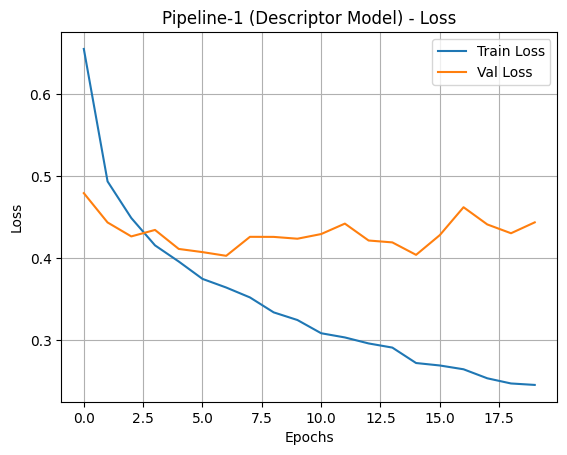

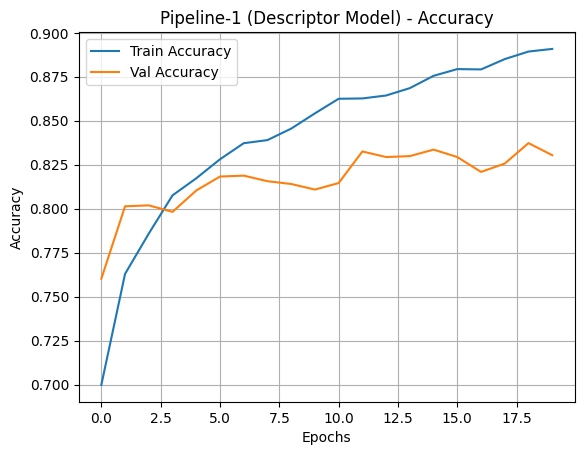

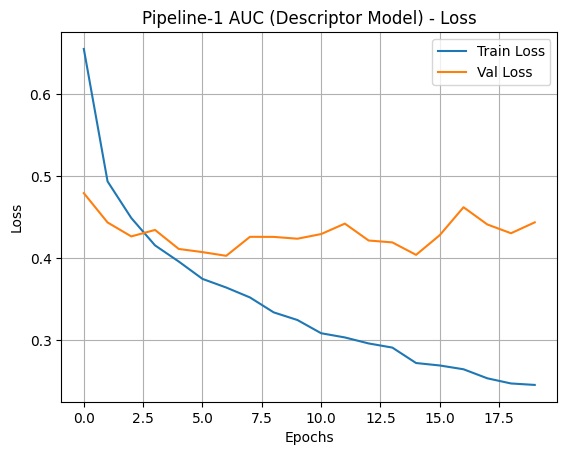

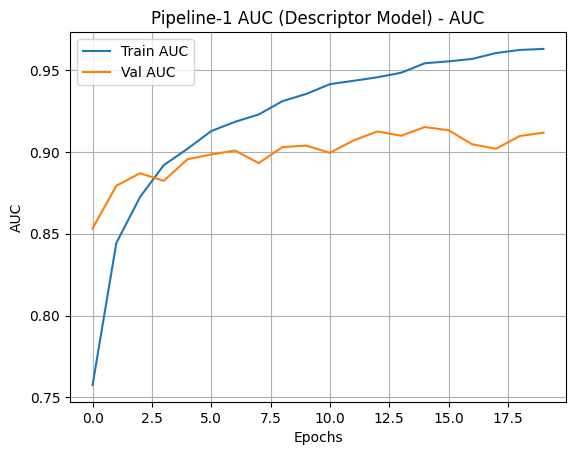

In [ ]:
plot_training_curves(
    history_p1,
    title_prefix="Pipeline-1 (Descriptor Model)"
)
plot_training_curves_auc(
    history_p1,
    title_prefix="Pipeline-1 AUC (Descriptor Model)"
)

Pipeline 2

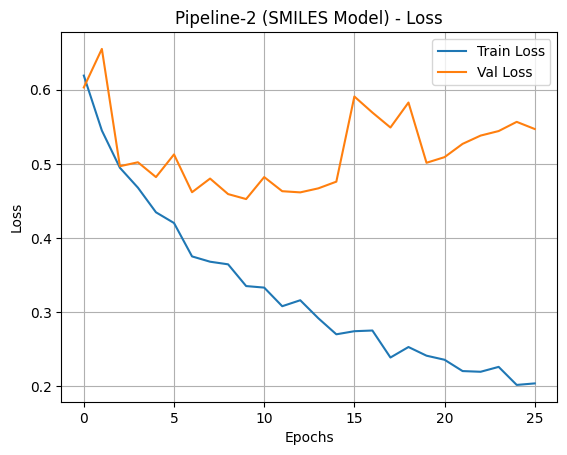

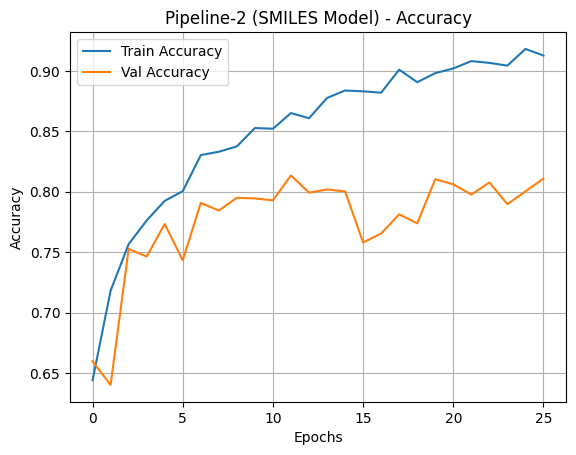

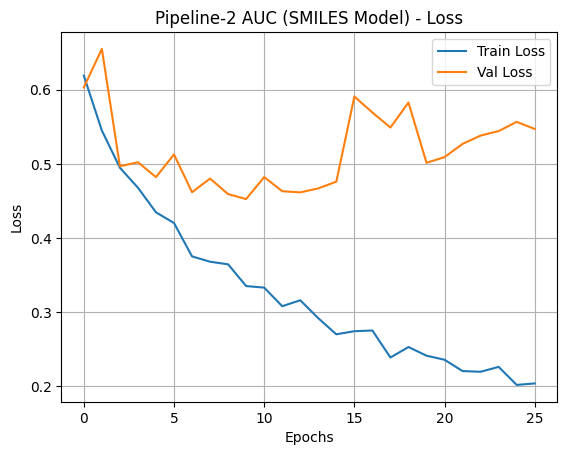

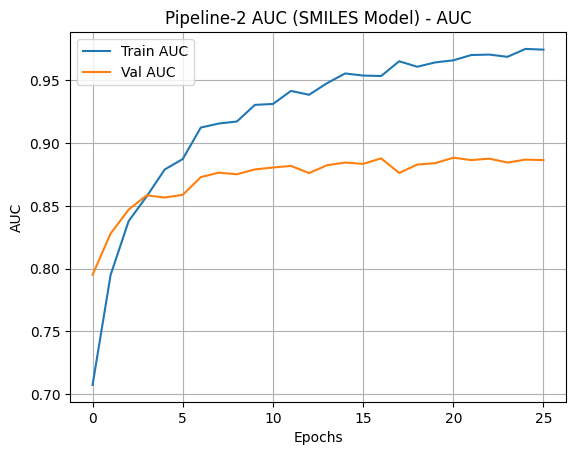

In [ ]:
plot_training_curves(
    history_p2,
    title_prefix="Pipeline-2 (SMILES Model)"
)
plot_training_curves_auc(
    history_p2,
    title_prefix="Pipeline-2 AUC (SMILES Model)"
)

Pipeline 3

In [ ]:
plot_training_curves(
    history_p3,
    title_prefix="Pipeline-3 (Image CNN Model)"
)
plot_training_curves_auc(
    history_p3,
    title_prefix="Pipeline-3 AUC (Image CNN Model)"
)

Fusion

In [ ]:
plot_training_curves(
    history_fusion,
    title_prefix="Fusion Model (Descriptors + SMILES + Images)"
)
plot_training_curves_auc(
    history_fusion,
    title_prefix="Fusion Model AUC (Descriptors + SMILES + Images)"
)